# Phase 2: Advanced Techniques on ConvNext

**Trial 1: Enhanced Data Augmentation**
- RandAugment / AutoAugment
- CutMix / MixUp
- Advanced transformations

**Trial 2: Regularization & Training**
- Label smoothing (ε=0.1)
- Stochastic depth / Dropout
- Longer training (40 epochs)
- Better learning rate schedule

**Trial 3: Progressive Training**
- Start with 224x224
- Progress to 288x288 or 384x384
- Multi-scale training

**Trial 4: Ensemble Methods**
- Train multiple models with different seeds
- Test-Time Augmentation (TTA)
- Model averaging

---

## 1. Setup & Configuration

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import random
from copy import deepcopy
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm.auto import tqdm
import cv2
from PIL import Image

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

Device: cuda
GPU: Tesla T4
Memory: 15.83 GB


In [4]:
CLASS_NAMES = {
    0: 'Groove_billed_Ani', 1: 'Red_winged_Blackbird', 2: 'Rusty_Blackbird',
    3: 'Gray_Catbird', 4: 'Brandt_Cormorant', 5: 'Eastern_Towhee',
    6: 'Indigo_Bunting', 7: 'Brewer_Blackbird', 8: 'Painted_Bunting',
    9: 'Bobolink', 10: 'Lazuli_Bunting', 11: 'Yellow_headed_Blackbird',
    12: 'American_Crow', 13: 'Fish_Crow', 14: 'Brown_Creeper',
    15: 'Yellow_billed_Cuckoo', 16: 'Yellow_breasted_Chat',
    17: 'Black_billed_Cuckoo', 18: 'Gray_crowned_Rosy_Finch', 19: 'Bronzed_Cowbird'
}

NUM_CLASSES = 20

CONFIG = {
    'data_dir': '/content/drive/MyDrive/data',
    'train_csv': '/content/drive/MyDrive/data/train_metadata.csv',
    'val_csv': '/content/drive/MyDrive/data/val_metadata.csv',
    'train_images': '/content/drive/MyDrive/data/train_images',
    'val_images': '/content/drive/MyDrive/data/val_images',
    'test_images': '/content/drive/MyDrive/data/test_images',
    'sample_submission': '/content/drive/MyDrive/data/sample_submission.csv',

    # Phase 1 checkpoint
    'phase1_checkpoint_dir': '/content/drive/My Drive/ml_results/phase1_checkpoints',

    # Training params
    'img_size': 224,  # Can try 288 and 384 later
    'batch_size': 32,
    'epochs': 40,
    'lr': 5e-5,
    'weight_decay': 1e-4,
    'num_workers': 4,

    # Advanced Techniques
    'use_mixup': True,
    'mixup_alpha': 0.2,
    'use_cutmix': True,
    'cutmix_alpha': 1.0,
    'label_smoothing': 0.1,
    'drop_path_rate': 0.1,

    # Output
    'checkpoint_dir': '/content/drive/My Drive/ml_results/phase2_checkpoints',
    'results_dir': '/content/drive/My Drive/ml_results/phase2_results',
}

os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)
os.makedirs(CONFIG['results_dir'], exist_ok=True)

## 2. Advanced Data Augmentation

In [5]:
# Dataset class
class BirdDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['path'])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, row['class_idx']

In [6]:
def get_advanced_transforms(img_size=224, mode='train'):
    """
    Advanced augmentation strategies for Phase 2
    """
    if mode == 'train':
        return A.Compose([
            # Geometric transforms
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.15,
                scale_limit=0.15,
                rotate_limit=30,
                p=0.5
            ),
            A.OneOf([
                A.Perspective(p=1),
                A.ElasticTransform(p=1),
            ], p=0.3),

            # Color transforms
            A.OneOf([
                A.RandomBrightnessContrast(
                    brightness_limit=0.3,
                    contrast_limit=0.3,
                    p=1
                ),
                A.HueSaturationValue(
                    hue_shift_limit=20,
                    sat_shift_limit=30,
                    val_shift_limit=20,
                    p=1
                ),
                A.ColorJitter(p=1),
            ], p=0.5),

            # Blur and noise
            A.OneOf([
                A.GaussianBlur(blur_limit=(3, 7), p=1),
                A.GaussNoise(var_limit=(10.0, 50.0), p=1),
                A.MotionBlur(blur_limit=5, p=1),
            ], p=0.3),

            # Dropout/cutout for regularization
            A.OneOf([
                A.CoarseDropout(
                    max_holes=8,
                    max_height=img_size//8,
                    max_width=img_size//8,
                    min_holes=1,
                    fill_value=0,
                    p=1
                ),
                A.GridDropout(ratio=0.2, p=1),
            ], p=0.3),

            # Normalize
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2(),
        ])

In [7]:
# Load data
train_df = pd.read_csv(CONFIG['train_csv'])
val_df = pd.read_csv(CONFIG['val_csv'])

train_dataset = BirdDataset(
    train_df,
    CONFIG['train_images'],
    get_advanced_transforms(CONFIG['img_size'], 'train')
)

val_dataset = BirdDataset(
    val_df,
    CONFIG['val_images'],
    get_advanced_transforms(CONFIG['img_size'], 'val')
)

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

## 3. MixUp & CutMix Implementation

In [8]:
def mixup_data(x, y, alpha=0.2):
    """Apply MixUp augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    """Apply CutMix augmentation"""
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    _, _, H, W = x.shape

    # Random box
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]

    # Adjust lambda
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def mixed_criterion(criterion, pred, y_a, y_b, lam):
    """Loss for mixed samples"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## 4. Label Smoothing Loss

In [9]:
class LabelSmoothingCrossEntropy(nn.Module):
    """
    Label smoothing to prevent overconfidence
    """
    def __init__(self, epsilon=0.1):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, preds, target):
        n_classes = preds.size(-1)
        log_preds = F.log_softmax(preds, dim=-1)

        # Smooth labels
        loss = -log_preds.sum(dim=-1).mean()
        nll = F.nll_loss(log_preds, target, reduction='mean')

        return self.epsilon * loss / n_classes + (1 - self.epsilon) * nll

## 5. Model Creation

In [10]:
def create_model(model_name='convnext_tiny', num_classes=NUM_CLASSES,
                pretrained=True, drop_path_rate=0.1):
    """
    Create ConvNeXt model with stochastic depth (drop path)
    """
    model = timm.create_model(
        model_name,
        pretrained=pretrained,
        num_classes=num_classes,
        drop_path_rate=drop_path_rate  # Stochastic depth
    )
    return model

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

## 6. Advanced Training Loop

In [11]:
def train_epoch_advanced(model, loader, criterion, optimizer, device, config):
    model.train()
    running_loss = 0.0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Randomly apply MixUp or CutMix
        r = np.random.rand()
        if config['use_mixup'] and r < 0.4:
            images, labels_a, labels_b, lam = mixup_data(
                images, labels, config['mixup_alpha']
            )
            use_mixed = True
        elif config['use_cutmix'] and r < 0.8:
            images, labels_a, labels_b, lam = cutmix_data(
                images, labels, config['cutmix_alpha']
            )
            use_mixed = True
        else:
            use_mixed = False

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        # Compute loss
        if use_mixed:
            loss = mixed_criterion(criterion, outputs, labels_a, labels_b, lam)
        else:
            loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item() * images.size(0)
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate(model, loader, criterion, device):
    """Standard validation"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [12]:
def train_model_advanced(model, train_loader, val_loader, experiment_name,
                        epochs=40, lr=5e-5, config=CONFIG):
    print(f"\n{'='*70}")
    print(f"PHASE 2 EXPERIMENT: {experiment_name}")
    print(f"{'='*70}")

    total_params, trainable_params = count_parameters(model)
    print(f"Parameters: {trainable_params:,} trainable / {total_params:,} total")
    print(f"MixUp: {config['use_mixup']}, CutMix: {config['use_cutmix']}")
    print(f"Label smoothing: {config['label_smoothing']}")
    print(f"Drop path rate: {config['drop_path_rate']}")

    # Setup
    model = model.to(device)

    # Label smoothing loss for training
    train_criterion = LabelSmoothingCrossEntropy(epsilon=config['label_smoothing'])
    # Standard CE for validation (to compare with Phase 1)
    val_criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=config['weight_decay']
    )

    # Cosine annealing with warmup
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=epochs,
        eta_min=1e-6
    )

    # Tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    best_val_acc = 0.0
    patience_counter = 0
    patience = 10  # Early stopping

    start_time = time.time()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Train
        train_loss = train_epoch_advanced(
            model, train_loader, train_criterion, optimizer, device, config
        )

        # Validate
        val_loss, val_acc, val_preds, val_labels = validate(
            model, val_loader, val_criterion, device
        )

        # Update scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Track
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"LR: {current_lr:.6f}")

        # Save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
                'config': config
            }
            torch.save(
                checkpoint,
                os.path.join(CONFIG['checkpoint_dir'], f'{experiment_name}_best.pth')
            )
            print(f"✓ Best model saved: {val_acc:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

    total_time = time.time() - start_time

    print(f"\n{'='*70}")
    print(f"Training Complete!")
    print(f"Best Val Accuracy: {best_val_acc:.4f}")
    print(f"Improvement over Phase 1: {(best_val_acc - 0.9223)*100:.2f}%")
    print(f"Total Time: {total_time/60:.2f} minutes")
    print(f"{'='*70}")

    return history, best_val_acc

## 7. Experiments

### Experiment 1: Full Advanced Pipeline (224x224)

In [ ]:
# Experiment 1: All techniques at 224x224
print("\n" + "#"*80)
print("EXPERIMENT 1: Full Advanced Training @ 224x224")
print("#"*80)

model_exp1 = create_model(
    'convnext_tiny',
    num_classes=NUM_CLASSES,
    pretrained=True,
    drop_path_rate=CONFIG['drop_path_rate']
)

history_exp1, best_acc_exp1 = train_model_advanced(
    model_exp1,
    train_loader,
    val_loader,
    experiment_name='convnext_advanced_224',
    epochs=CONFIG['epochs'],
    lr=CONFIG['lr'],
    config=CONFIG
)

# Clear memory
del model_exp1
torch.cuda.empty_cache()


################################################################################
EXPERIMENT 1: Full Advanced Training @ 224x224
################################################################################

PHASE 2 EXPERIMENT: convnext_advanced_224
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.5609
Val Loss: 0.8827, Val Acc: 0.7573
LR: 0.000050
✓ Best model saved: 0.7573

Epoch 2/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.8396
Val Loss: 0.4638, Val Acc: 0.8641
LR: 0.000050
✓ Best model saved: 0.8641

Epoch 3/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4553
Val Loss: 0.4465, Val Acc: 0.8447
LR: 0.000049

Epoch 4/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4685
Val Loss: 0.4114, Val Acc: 0.8738
LR: 0.000049
✓ Best model saved: 0.8738

Epoch 5/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3064
Val Loss: 0.4034, Val Acc: 0.8738
LR: 0.000048

Epoch 6/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4105
Val Loss: 0.4195, Val Acc: 0.8641
LR: 0.000047

Epoch 7/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3377
Val Loss: 0.3825, Val Acc: 0.8932
LR: 0.000046
✓ Best model saved: 0.8932

Epoch 8/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4126
Val Loss: 0.4210, Val Acc: 0.8544
LR: 0.000045

Epoch 9/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3416
Val Loss: 0.3354, Val Acc: 0.9029
LR: 0.000044
✓ Best model saved: 0.9029

Epoch 10/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1447
Val Loss: 0.3586, Val Acc: 0.9029
LR: 0.000043

Epoch 11/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2194
Val Loss: 0.3117, Val Acc: 0.9223
LR: 0.000041
✓ Best model saved: 0.9223

Epoch 12/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2362
Val Loss: 0.2975, Val Acc: 0.9126
LR: 0.000040

Epoch 13/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1937
Val Loss: 0.3088, Val Acc: 0.9126
LR: 0.000038

Epoch 14/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1832
Val Loss: 0.3509, Val Acc: 0.9126
LR: 0.000037

Epoch 15/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1864
Val Loss: 0.3157, Val Acc: 0.9126
LR: 0.000035

Epoch 16/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7871be9cca40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7871be9cca40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2552
Val Loss: 0.2697, Val Acc: 0.9320
LR: 0.000033
✓ Best model saved: 0.9320

Epoch 17/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1818
Val Loss: 0.2626, Val Acc: 0.9709
LR: 0.000031
✓ Best model saved: 0.9709

Epoch 18/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1771
Val Loss: 0.2838, Val Acc: 0.9223
LR: 0.000029

Epoch 19/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7871be9cca40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7871be9cca40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0672
Val Loss: 0.2413, Val Acc: 0.9515
LR: 0.000027

Epoch 20/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1181
Val Loss: 0.2507, Val Acc: 0.9515
LR: 0.000025

Epoch 21/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9883
Val Loss: 0.3089, Val Acc: 0.9320
LR: 0.000024

Epoch 22/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0152
Val Loss: 0.2730, Val Acc: 0.9515
LR: 0.000022

Epoch 23/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7871be9cca40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7871be9cca40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0486
Val Loss: 0.3381, Val Acc: 0.9320
LR: 0.000020

Epoch 24/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1065
Val Loss: 0.2789, Val Acc: 0.9417
LR: 0.000018

Epoch 25/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1737
Val Loss: 0.3073, Val Acc: 0.9223
LR: 0.000016

Epoch 26/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1053
Val Loss: 0.2756, Val Acc: 0.9515
LR: 0.000014

Epoch 27/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7871be9cca40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7871be9cca40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9586
Val Loss: 0.3347, Val Acc: 0.9223
LR: 0.000013

Early stopping at epoch 27

Training Complete!
Best Val Accuracy: 0.9709
Improvement over Phase 1: 4.86%
Total Time: 29.83 minutes


### Experiment 2: Progressive Training (224 → 288)

In [ ]:
# Experiment 2: Progressive resizing
print("\n" + "#"*80)
print("EXPERIMENT 2: Progressive Training 224 → 288")
print("#"*80)

# Stage 1: Train at 224
print("\nStage 1: Training at 224x224 (20 epochs)...")
model_exp2 = create_model(
    'convnext_tiny',
    num_classes=NUM_CLASSES,
    pretrained=True,
    drop_path_rate=CONFIG['drop_path_rate']
)

config_stage1 = CONFIG.copy()
config_stage1['img_size'] = 224

history_stage1, _ = train_model_advanced(
    model_exp2,
    train_loader,
    val_loader,
    experiment_name='convnext_progressive_stage1',
    epochs=20,
    lr=CONFIG['lr'],
    config=config_stage1
)

# Stage 2: Continue at 288
print("\nStage 2: Continuing at 288x288 (20 epochs)...")

# Create new dataloaders at 288
train_dataset_288 = BirdDataset(
    train_df,
    CONFIG['train_images'],
    get_advanced_transforms(288, 'train')
)

val_dataset_288 = BirdDataset(
    val_df,
    CONFIG['val_images'],
    get_advanced_transforms(288, 'val')
)

train_loader_288 = DataLoader(
    train_dataset_288,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader_288 = DataLoader(
    val_dataset_288,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

config_stage2 = CONFIG.copy()
config_stage2['img_size'] = 288

history_stage2, best_acc_exp2 = train_model_advanced(
    model_exp2,
    train_loader_288,
    val_loader_288,
    experiment_name='convnext_progressive_288',
    epochs=20,
    lr=CONFIG['lr'] / 2,  # Lower LR for fine-tuning
    config=config_stage2
)

# Clear memory
del model_exp2, train_loader_288, val_loader_288
torch.cuda.empty_cache()


################################################################################
EXPERIMENT 2: Progressive Training 224 → 288
################################################################################

Stage 1: Training at 224x224 (20 epochs)...

PHASE 2 EXPERIMENT: convnext_progressive_stage1
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.5059
Val Loss: 0.7811, Val Acc: 0.7864
LR: 0.000050
✓ Best model saved: 0.7864

Epoch 2/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.8077
Val Loss: 0.5117, Val Acc: 0.8350
LR: 0.000049
✓ Best model saved: 0.8350

Epoch 3/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.5790
Val Loss: 0.4307, Val Acc: 0.8738
LR: 0.000047
✓ Best model saved: 0.8738

Epoch 4/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3239
Val Loss: 0.3469, Val Acc: 0.9126
LR: 0.000045
✓ Best model saved: 0.9126

Epoch 5/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3793
Val Loss: 0.3523, Val Acc: 0.9029
LR: 0.000043

Epoch 6/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3687
Val Loss: 0.3429, Val Acc: 0.9126
LR: 0.000040

Epoch 7/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3037
Val Loss: 0.3216, Val Acc: 0.9223
LR: 0.000037
✓ Best model saved: 0.9223

Epoch 8/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2962
Val Loss: 0.3359, Val Acc: 0.8932
LR: 0.000033

Epoch 9/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2515
Val Loss: 0.2701, Val Acc: 0.8932
LR: 0.000029

Epoch 10/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.3288
Val Loss: 0.3053, Val Acc: 0.9029
LR: 0.000025

Epoch 11/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2481
Val Loss: 0.2930, Val Acc: 0.9320
LR: 0.000022
✓ Best model saved: 0.9320

Epoch 12/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1897
Val Loss: 0.3169, Val Acc: 0.9320
LR: 0.000018

Epoch 13/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0732
Val Loss: 0.2913, Val Acc: 0.9126
LR: 0.000014

Epoch 14/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1632
Val Loss: 0.2926, Val Acc: 0.9126
LR: 0.000011

Epoch 15/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0090
Val Loss: 0.2926, Val Acc: 0.9320
LR: 0.000008

Epoch 16/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0585
Val Loss: 0.2738, Val Acc: 0.9320
LR: 0.000006

Epoch 17/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0872
Val Loss: 0.2686, Val Acc: 0.9320
LR: 0.000004

Epoch 18/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1612
Val Loss: 0.2664, Val Acc: 0.9223
LR: 0.000002

Epoch 19/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2169
Val Loss: 0.2637, Val Acc: 0.9223
LR: 0.000001

Epoch 20/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1549
Val Loss: 0.2664, Val Acc: 0.9223
LR: 0.000001

Training Complete!
Best Val Accuracy: 0.9320
Improvement over Phase 1: 0.97%
Total Time: 12.67 minutes

Stage 2: Continuing at 288x288 (20 epochs)...

PHASE 2 EXPERIMENT: convnext_progressive_288
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9937
Val Loss: 0.3157, Val Acc: 0.9223
LR: 0.000025
✓ Best model saved: 0.9223

Epoch 2/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1874
Val Loss: 0.2477, Val Acc: 0.9417
LR: 0.000024
✓ Best model saved: 0.9417

Epoch 3/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1651
Val Loss: 0.3030, Val Acc: 0.9223
LR: 0.000024

Epoch 4/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.2075
Val Loss: 0.2985, Val Acc: 0.9320
LR: 0.000023

Epoch 5/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1466
Val Loss: 0.3280, Val Acc: 0.9320
LR: 0.000021

Epoch 6/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1570
Val Loss: 0.3025, Val Acc: 0.9417
LR: 0.000020

Epoch 7/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0803
Val Loss: 0.3124, Val Acc: 0.9417
LR: 0.000018

Epoch 8/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1984
Val Loss: 0.2818, Val Acc: 0.9320
LR: 0.000017

Epoch 9/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0191
Val Loss: 0.2729, Val Acc: 0.9320
LR: 0.000015

Epoch 10/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0691
Val Loss: 0.2878, Val Acc: 0.9223
LR: 0.000013

Epoch 11/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1004
Val Loss: 0.2702, Val Acc: 0.9417
LR: 0.000011

Epoch 12/20


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1211
Val Loss: 0.2664, Val Acc: 0.9417
LR: 0.000009

Early stopping at epoch 12

Training Complete!
Best Val Accuracy: 0.9417
Improvement over Phase 1: 1.94%
Total Time: 6.28 minutes


### Experiment 3: Ensemble Training (Multiple Seeds)

In [ ]:
# Experiment 3: Train 3 models with different seeds for ensemble
print("\n" + "#"*80)
print("EXPERIMENT 3: Ensemble Training (3 models)")
print("#"*80)

ensemble_results = []
seeds = [42, 123, 777]

for i, seed in enumerate(seeds, 1):
    print(f"\n{'='*50}")
    print(f"Training Ensemble Model {i}/3 (seed={seed})")
    print(f"{'='*50}")

    set_seed(seed)

    model = create_model(
        'convnext_tiny',
        num_classes=NUM_CLASSES,
        pretrained=True,
        drop_path_rate=CONFIG['drop_path_rate']
    )

    history, best_acc = train_model_advanced(
        model,
        train_loader,
        val_loader,
        experiment_name=f'convnext_ensemble_{i}_seed{seed}',
        epochs=30,  # Slightly fewer epochs per model
        lr=CONFIG['lr'],
        config=CONFIG
    )

    ensemble_results.append({
        'seed': seed,
        'best_acc': best_acc,
        'history': history
    })

    del model
    torch.cuda.empty_cache()

print("\n" + "="*70)
print("Ensemble Training Complete!")
for i, result in enumerate(ensemble_results, 1):
    print(f"Model {i} (seed={result['seed']}): {result['best_acc']:.4f}")
print(f"Mean accuracy: {np.mean([r['best_acc'] for r in ensemble_results]):.4f}")
print("="*70)


################################################################################
EXPERIMENT 3: Ensemble Training (3 models)
################################################################################

Training Ensemble Model 1/3 (seed=42)

PHASE 2 EXPERIMENT: convnext_ensemble_1_seed42
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.6728
Val Loss: 0.8707, Val Acc: 0.8252
LR: 0.000050
✓ Best model saved: 0.8252

Epoch 2/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.6656
Val Loss: 0.4905, Val Acc: 0.8738
LR: 0.000049
✓ Best model saved: 0.8738

Epoch 3/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4951
Val Loss: 0.3531, Val Acc: 0.9223
LR: 0.000049
✓ Best model saved: 0.9223

Epoch 4/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.5195
Val Loss: 0.3717, Val Acc: 0.9029
LR: 0.000048

Epoch 5/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.5312
Val Loss: 0.4008, Val Acc: 0.8641
LR: 0.000047

Epoch 6/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3902
Val Loss: 0.3929, Val Acc: 0.9029
LR: 0.000045

Epoch 7/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3481
Val Loss: 0.3529, Val Acc: 0.8835
LR: 0.000044

Epoch 8/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2895
Val Loss: 0.3233, Val Acc: 0.9223
LR: 0.000042

Epoch 9/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2460
Val Loss: 0.2872, Val Acc: 0.9320
LR: 0.000040
✓ Best model saved: 0.9320

Epoch 10/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1972
Val Loss: 0.3181, Val Acc: 0.9126
LR: 0.000038

Epoch 11/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1546
Val Loss: 0.2872, Val Acc: 0.9417
LR: 0.000035
✓ Best model saved: 0.9417

Epoch 12/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3435
Val Loss: 0.2736, Val Acc: 0.9417
LR: 0.000033

Epoch 13/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2098
Val Loss: 0.2848, Val Acc: 0.9417
LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1288
Val Loss: 0.3273, Val Acc: 0.9223
LR: 0.000028

Epoch 15/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2233
Val Loss: 0.3086, Val Acc: 0.9320
LR: 0.000026

Epoch 16/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.1359
Val Loss: 0.3402, Val Acc: 0.9029
LR: 0.000023

Epoch 17/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0304
Val Loss: 0.3383, Val Acc: 0.9320
LR: 0.000020

Epoch 18/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1092
Val Loss: 0.3091, Val Acc: 0.9417
LR: 0.000018

Epoch 19/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2785
Val Loss: 0.2754, Val Acc: 0.9515
LR: 0.000016
✓ Best model saved: 0.9515

Epoch 20/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0481
Val Loss: 0.2758, Val Acc: 0.9515
LR: 0.000013

Epoch 21/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1587
Val Loss: 0.2901, Val Acc: 0.9320
LR: 0.000011

Epoch 22/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0045
Val Loss: 0.3072, Val Acc: 0.9320
LR: 0.000009

Epoch 23/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1757
Val Loss: 0.2688, Val Acc: 0.9515
LR: 0.000007

Epoch 24/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>^
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1203
Val Loss: 0.2577, Val Acc: 0.9612
LR: 0.000006
✓ Best model saved: 0.9612

Epoch 25/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2164
Val Loss: 0.2924, Val Acc: 0.9223
LR: 0.000004

Epoch 26/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1327
Val Loss: 0.2637, Val Acc: 0.9320
LR: 0.000003

Epoch 27/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9743
Val Loss: 0.2782, Val Acc: 0.9320
LR: 0.000002

Epoch 28/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0580
Val Loss: 0.2605, Val Acc: 0.9320
LR: 0.000002

Epoch 29/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0945
Val Loss: 0.2665, Val Acc: 0.9320
LR: 0.000001

Epoch 30/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0869
Val Loss: 0.2652, Val Acc: 0.9320
LR: 0.000001

Training Complete!
Best Val Accuracy: 0.9612
Improvement over Phase 1: 3.89%
Total Time: 16.86 minutes

Training Ensemble Model 2/3 (seed=123)

PHASE 2 EXPERIMENT: convnext_ensemble_2_seed123
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.7383
Val Loss: 1.0719, Val Acc: 0.7767
LR: 0.000050
✓ Best model saved: 0.7767

Epoch 2/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.7937
Val Loss: 0.5303, Val Acc: 0.8738
LR: 0.000049
✓ Best model saved: 0.8738

Epoch 3/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.5299
Val Loss: 0.4376, Val Acc: 0.8932
LR: 0.000049
✓ Best model saved: 0.8932

Epoch 4/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4582
Val Loss: 0.3801, Val Acc: 0.8738
LR: 0.000048

Epoch 5/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3461
Val Loss: 0.3006, Val Acc: 0.9223
LR: 0.000047
✓ Best model saved: 0.9223

Epoch 6/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4554
Val Loss: 0.3583, Val Acc: 0.9126
LR: 0.000045

Epoch 7/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4264
Val Loss: 0.3812, Val Acc: 0.9029
LR: 0.000044

Epoch 8/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3518
Val Loss: 0.3628, Val Acc: 0.9223
LR: 0.000042

Epoch 9/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2587
Val Loss: 0.3472, Val Acc: 0.9126
LR: 0.000040

Epoch 10/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>Exception ignored in:     se

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2773
Val Loss: 0.2927, Val Acc: 0.9223
LR: 0.000038

Epoch 11/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2903
Val Loss: 0.3086, Val Acc: 0.9029
LR: 0.000035

Epoch 12/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3017
Val Loss: 0.3292, Val Acc: 0.9126
LR: 0.000033

Epoch 13/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1464
Val Loss: 0.3197, Val Acc: 0.9223
LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    Traceback (most recent call last):
Exception ignored in: self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
    
Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

          File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():self._sh

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2123
Val Loss: 0.2853, Val Acc: 0.9223
LR: 0.000028

Epoch 15/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2991
Val Loss: 0.2907, Val Acc: 0.9223
LR: 0.000026

Early stopping at epoch 15

Training Complete!
Best Val Accuracy: 0.9223
Improvement over Phase 1: 0.00%
Total Time: 6.45 minutes

Training Ensemble Model 3/3 (seed=777)

PHASE 2 EXPERIMENT: convnext_ensemble_3_seed777
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/30


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Training:   0%|          | 0/34 [00:01<?, ?it/s]

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
^ ^ ^ ^ ^ ^ ^ ^ ^^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^AssertionError^: ^can only test a child process^
^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.6486
Val Loss: 0.9098, Val Acc: 0.7961
LR: 0.000050
✓ Best model saved: 0.7961

Epoch 2/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.9038
Val Loss: 0.5239, Val Acc: 0.8544
LR: 0.000049
✓ Best model saved: 0.8544

Epoch 3/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.5961
Val Loss: 0.4525, Val Acc: 0.8544
LR: 0.000049

Epoch 4/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4778
Val Loss: 0.3568, Val Acc: 0.9029
LR: 0.000048
✓ Best model saved: 0.9029

Epoch 5/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3191
Val Loss: 0.4260, Val Acc: 0.8738
LR: 0.000047

Epoch 6/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3634
Val Loss: 0.3835, Val Acc: 0.8835
LR: 0.000045

Epoch 7/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2807
Val Loss: 0.3373, Val Acc: 0.9029
LR: 0.000044

Epoch 8/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3199
Val Loss: 0.3289, Val Acc: 0.9029
LR: 0.000042

Epoch 9/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1958
Val Loss: 0.3920, Val Acc: 0.8932
LR: 0.000040

Epoch 10/30


Training:   0%|          | 0/34 [01:20<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3239
Val Loss: 0.3600, Val Acc: 0.9126
LR: 0.000038
✓ Best model saved: 0.9126

Epoch 11/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2659
Val Loss: 0.2905, Val Acc: 0.9126
LR: 0.000035

Epoch 12/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1357
Val Loss: 0.3544, Val Acc: 0.8932
LR: 0.000033

Epoch 13/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: 

Train Loss: 1.1958
Val Loss: 0.3920, Val Acc: 0.8932
LR: 0.000040

Epoch 10/30
Train Loss: 1.1958
Val Loss: 0.3920, Val Acc: 0.8932
LR: 0.000040

Epoch 10/30
Train Loss: 1.1958
Val Loss: 0.3920, Val Acc: 0.8932
LR: 0.000040

Epoch 10/30


<function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>

Train Loss: 1.1958
Val Loss: 0.3920, Val Acc: 0.8932
LR: 0.000040

Epoch 10/30



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python

Train Loss: 1.2484
Val Loss: 0.3922, Val Acc: 0.8932
LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3112
Val Loss: 0.3422, Val Acc: 0.9029
LR: 0.000028

Epoch 15/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2277
Val Loss: 0.2719, Val Acc: 0.9320
LR: 0.000026
✓ Best model saved: 0.9320

Epoch 16/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1919
Val Loss: 0.2781, Val Acc: 0.9417
LR: 0.000023
✓ Best model saved: 0.9417

Epoch 17/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2231
Val Loss: 0.2739, Val Acc: 0.9417
LR: 0.000020

Epoch 18/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0693
Val Loss: 0.2951, Val Acc: 0.9417
LR: 0.000018

Epoch 19/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1163
Val Loss: 0.2991, Val Acc: 0.9515
LR: 0.000016
✓ Best model saved: 0.9515

Epoch 20/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2064
Val Loss: 0.2829, Val Acc: 0.9320
LR: 0.000013

Epoch 21/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0752
Val Loss: 0.2651, Val Acc: 0.9515
LR: 0.000011

Epoch 22/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1724
Val Loss: 0.3101, Val Acc: 0.9223
LR: 0.000009

Epoch 23/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1344
Val Loss: 0.2870, Val Acc: 0.9223
LR: 0.000007

Epoch 24/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x784d459ac040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 1.0155
Val Loss: 0.2865, Val Acc: 0.9126
LR: 0.000006

Epoch 25/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2125
Val Loss: 0.2886, Val Acc: 0.9126
LR: 0.000004

Epoch 26/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9277
Val Loss: 0.2805, Val Acc: 0.9223
LR: 0.000003

Epoch 27/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0386
Val Loss: 0.2835, Val Acc: 0.9320
LR: 0.000002

Epoch 28/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1449
Val Loss: 0.2900, Val Acc: 0.9029
LR: 0.000002

Epoch 29/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0531
Val Loss: 0.2909, Val Acc: 0.9223
LR: 0.000001

Early stopping at epoch 29

Training Complete!
Best Val Accuracy: 0.9515
Improvement over Phase 1: 2.92%
Total Time: 25.25 minutes

Ensemble Training Complete!
Model 1 (seed=42): 0.9612
Model 2 (seed=123): 0.9223
Model 3 (seed=777): 0.9515
Mean accuracy: 0.9450


## 8. Phase 2 Results Analysis

In [ ]:
phase2_results = pd.DataFrame([
    {
        'Experiment': 'Phase 1 Baseline',
        'Accuracy': 0.9223,
        'Description': 'ConvNeXt-Tiny, basic aug'
    },
    {
        'Experiment': 'Exp 1: Advanced Training',
        'Accuracy': best_acc_exp1,
        'Description': 'MixUp + CutMix + Label Smoothing @ 224'
    },
    {
        'Experiment': 'Exp 2: Progressive',
        'Accuracy': best_acc_exp2,
        'Description': '224→288 progressive training'
    },
    {
        'Experiment': 'Exp 3: Ensemble (avg)',
        'Accuracy': np.mean([r['best_acc'] for r in ensemble_results]),
        'Description': 'Mean of 3 models (different seeds)'
    },
])

phase2_results = phase2_results.sort_values('Accuracy', ascending=False)

print("\n" + "="*80)
print("PHASE 2 RESULTS SUMMARY")
print("="*80)
display(phase2_results)

phase2_results.to_csv(
    os.path.join(CONFIG['results_dir'], 'phase2_results.csv'),
    index=False
)
print("\n✓ Results saved")


PHASE 2 RESULTS SUMMARY


Experiment  Accuracy                             Description
3     Exp 3: Ensemble (avg)  0.944984      Mean of 3 models (different seeds)
1  Exp 1: Advanced Training  0.941748  MixUp + CutMix + Label Smoothing @ 224
2        Exp 2: Progressive  0.941748            224→288 progressive training
0          Phase 1 Baseline  0.922300                ConvNeXt-Tiny, basic aug


✓ Results saved


In [ ]:
phase2_results = pd.DataFrame([
    {
        'Experiment': 'Phase 1 Baseline',
        'Accuracy': 0.9223,
        'Description': 'ConvNeXt-Tiny, basic aug'
    },
    {
        'Experiment': 'Exp 1: Advanced Training',
        'Accuracy': best_acc_exp1,
        'Description': 'MixUp + CutMix + Label Smoothing @ 224'
    },
    {
        'Experiment': 'Exp 2: Progressive',
        'Accuracy': best_acc_exp2,
        'Description': '224→288 progressive training'
    },
    {
        'Experiment': 'Exp 3: Ensemble (avg)',
        'Accuracy': np.mean([r['best_acc'] for r in ensemble_results]),
        'Description': 'Mean of 3 models (different seeds)'
    },
])

phase2_results = phase2_results.sort_values('Accuracy', ascending=False)

print("\n" + "="*80)
print("PHASE 2 RESULTS SUMMARY")
print("="*80)
display(phase2_results)

phase2_results.to_csv(
    os.path.join(CONFIG['results_dir'], 'phase2_results.csv'),
    index=False
)
print("\n✓ Results saved")

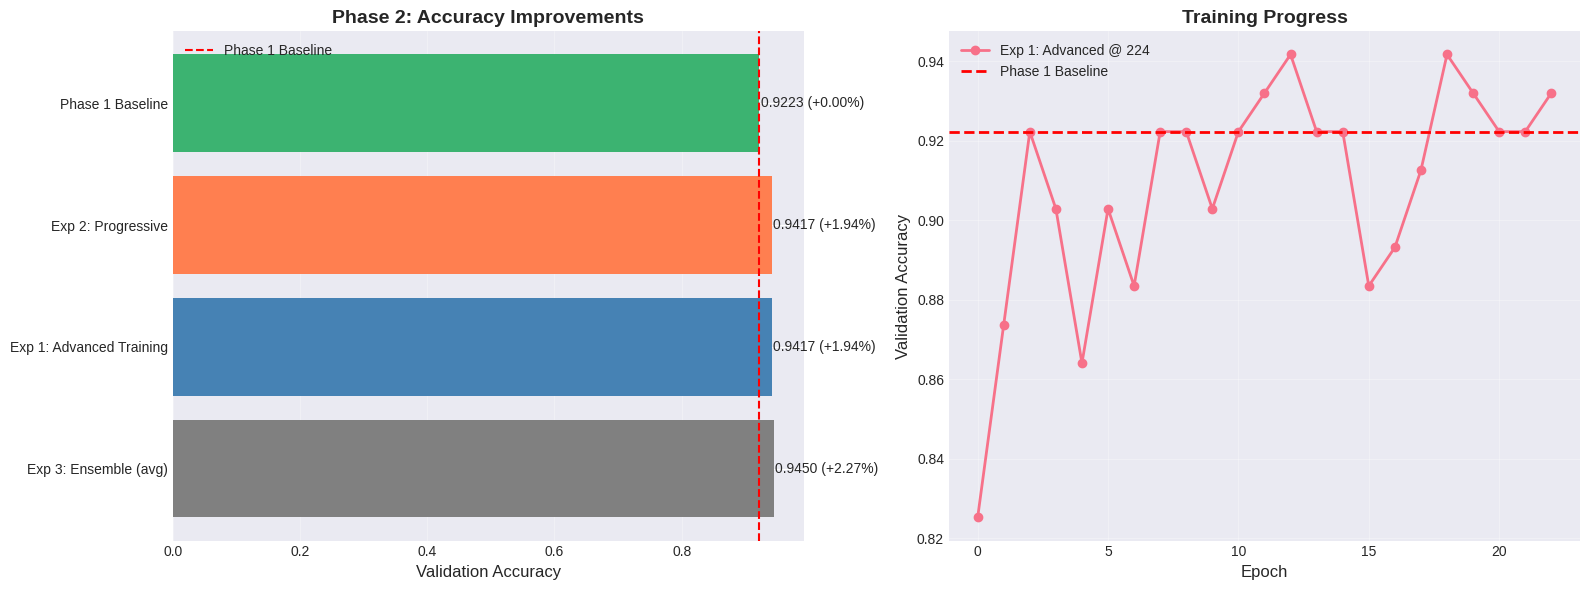

✓ Visualization saved


In [ ]:
# Visualize improvements
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
experiments = phase2_results['Experiment'].values
accuracies = phase2_results['Accuracy'].values
colors = ['gray'] + ['steelblue', 'coral', 'mediumseagreen']

axes[0].barh(experiments, accuracies, color=colors)
axes[0].set_xlabel('Validation Accuracy', fontsize=12)
axes[0].set_title('Phase 2: Accuracy Improvements', fontsize=14, fontweight='bold')
axes[0].axvline(0.9223, color='red', linestyle='--', label='Phase 1 Baseline')
axes[0].grid(axis='x', alpha=0.3)
axes[0].legend()

for i, v in enumerate(accuracies):
    improvement = (v - 0.9223) * 100
    axes[0].text(v + 0.002, i, f'{v:.4f} (+{improvement:.2f}%)', va='center')

# Training curves comparison
axes[1].plot(history_exp1['val_acc'], label='Exp 1: Advanced @ 224', marker='o', linewidth=2)
axes[1].axhline(0.9223, color='red', linestyle='--', label='Phase 1 Baseline', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Accuracy', fontsize=12)
axes[1].set_title('Training Progress', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    os.path.join(CONFIG['results_dir'], 'phase2_improvements.png'),
    dpi=150, bbox_inches='tight'
)
plt.show()

print('✓ Visualization saved')

## 9. Ensemble Prediction with Test-Time Augmentation

In [ ]:
def predict_with_tta(model, image, n_tta=5):
    """
    Test-time augmentation for better predictions
    """
    model.eval()

    # TTA transforms
    tta_transforms = [
        get_advanced_transforms(CONFIG['img_size'], 'val'),  # Original
        A.Compose([A.HorizontalFlip(p=1.0)] +
                 get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
        A.Compose([A.Rotate(limit=10, p=1.0)] +
                 get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
        A.Compose([A.Rotate(limit=-10, p=1.0)] +
                 get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
        A.Compose([A.RandomBrightnessContrast(p=1.0)] +
                 get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
    ]

    predictions = []

    with torch.no_grad():
        for transform in tta_transforms[:n_tta]:
            augmented = transform(image=image)['image']
            augmented = augmented.unsqueeze(0).to(device)

            output = model(augmented)
            probs = F.softmax(output, dim=1)
            predictions.append(probs.cpu().numpy())

    # Average predictions
    avg_pred = np.mean(predictions, axis=0)
    return avg_pred

✓ TTA function defined


In [ ]:
# Load best model from Phase 2
best_model_name = 'convnext_ensemble_1_seed42'  # Change based on best experiment

print(f"Loading best Phase 2 model: {best_model_name}")

model = create_model(
    'convnext_tiny',
    num_classes=NUM_CLASSES,
    pretrained=False,
    drop_path_rate=0  # No dropout for inference
)

checkpoint_path = os.path.join(CONFIG['checkpoint_dir'], f'{best_model_name}_best.pth')
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✓ Model loaded (Val Acc: {checkpoint['val_acc']:.4f})")

Loading best Phase 2 model: convnext_ensemble_1_seed42
✓ Model loaded (Val Acc: 0.9612)


Transform ready: True
Found 400 test images
Running TTA predictions...


  0%|          | 0/400 [00:00<?, ?it/s]

✓ Saved /content/drive/My Drive/ml_results/phase2_results/submission_phase2_convnext_ensemble_1_seed42_tta.csv
Predictions: 400
0     23
1     14
2     23
3     22
4     21
5     19
6     15
7     19
8     15
9     25
10    19
11    19
12    14
13    24
14    21
15    29
16    23
17    19
18    18
19    18
Name: count, dtype: int64


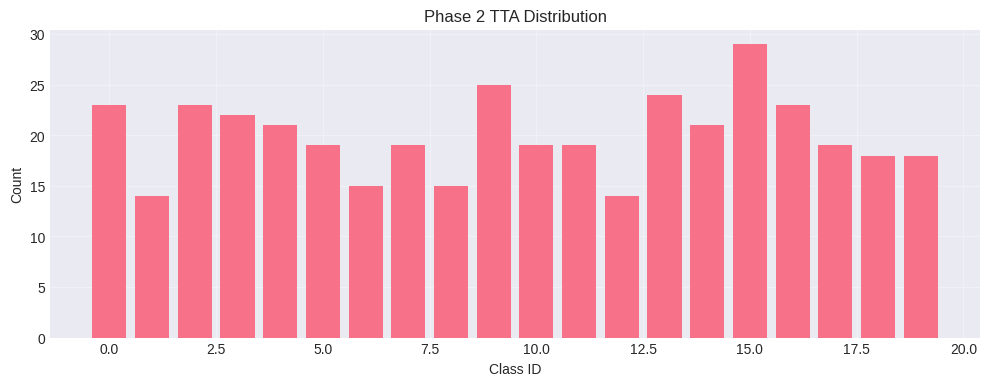

In [ ]:
test_transform = get_advanced_transforms(CONFIG['img_size'], 'val')
print(f"Transform ready: {test_transform is not None}")

test_image_paths = []
for root, dirs, files in os.walk(CONFIG['test_images']):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            test_image_paths.append(os.path.join(root, file))

print(f"Found {len(test_image_paths)} test images")

# Generate predictions
predictions = []
print("Running TTA predictions...")

for img_path in tqdm(test_image_paths):
    # Safe loading matching your original
    image = cv2.imread(img_path)
    if image is None or image.size == 0:
        image = np.zeros((CONFIG['img_size'], CONFIG['img_size'], 3), dtype=np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    avg_pred = predict_with_tta(model, image, n_tta=5)
    predictions.append(int(np.argmax(avg_pred)))

# Save submission
submission = pd.DataFrame({
    'path': [os.path.basename(p) for p in test_image_paths],
    'class_idx': predictions
})

submission_path = os.path.join(CONFIG['results_dir'], f'submission_phase2_{best_model_name}_tta.csv')
submission.to_csv(submission_path, index=False)

print(f"✓ Saved {submission_path}")
print(f"Predictions: {len(predictions)}")
print(pd.Series(predictions).value_counts().sort_index())

# 5. Plot
plt.figure(figsize=(12, 4))
plt.bar(pd.Series(predictions).value_counts().sort_index().index,
        pd.Series(predictions).value_counts().sort_index().values)
plt.title('Phase 2 TTA Distribution')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(CONFIG['results_dir'], 'phase2_tta_dist.png'), dpi=150)
plt.show()


In [16]:
# ============================================================================
# EXPERIMENT 4: YOLO PREPROCESSING
# Train on YOLO bird-cropped images for better focus on the bird
# ============================================================================

"""## 10. Experiment 4: YOLO Preprocessing

**IMPORTANT: Yes, test images MUST also be YOLO preprocessed!**
If you train on cropped bird images, you must also crop bird images during test inference.
Otherwise there's a distribution mismatch that kills accuracy.
"""

print("\n" + "#"*80)
print("EXPERIMENT 4: YOLO Preprocessing")
print("Training on YOLO bird-cropped images")
print("#"*80)

# Install ultralytics if needed
try:
    from ultralytics import YOLO
    print("✓ YOLO already available")
except ImportError:
    print("Installing ultralytics...")
    import subprocess
    subprocess.run(['pip', 'install', 'ultralytics', '-q'])
    from ultralytics import YOLO
    print("✓ YOLO installed")




################################################################################
EXPERIMENT 4: YOLO Preprocessing
Training on YOLO bird-cropped images
################################################################################
Installing ultralytics...
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✓ YOLO installed


In [17]:
# YOLO Bird Detector
class YOLOBirdDetector:
    """Detect and crop birds from images using YOLO"""

    def __init__(self, model_name='yolov8n.pt', conf_threshold=0.25, expand_bbox=0.1):
        self.model = YOLO(model_name)
        self.conf_threshold = conf_threshold
        self.expand_bbox = expand_bbox
        # COCO bird class ID is 14
        self.bird_class_id = 14

    def detect_and_crop(self, image_path):
        """Detect bird and return cropped image, or original if no bird found"""
        # Read image
        image = cv2.imread(image_path)
        if image is None:
            return None
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Run detection
        results = self.model(image_rgb, verbose=False, conf=self.conf_threshold)

        # Find bird detections
        for result in results:
            boxes = result.boxes
            for i, box in enumerate(boxes):
                cls = int(box.cls[0])
                conf = float(box.conf[0])

                if cls == self.bird_class_id and conf >= self.conf_threshold:
                    # Get bounding box
                    x1, y1, x2, y2 = map(int, box.xyxy[0])

                    # Expand bbox slightly
                    h, w = image.shape[:2]
                    expand_w = int((x2 - x1) * self.expand_bbox)
                    expand_h = int((y2 - y1) * self.expand_bbox)

                    x1 = max(0, x1 - expand_w)
                    y1 = max(0, y1 - expand_h)
                    x2 = min(w, x2 + expand_w)
                    y2 = min(h, y2 + expand_h)

                    # Crop and return
                    cropped = image_rgb[y1:y2, x1:x2]
                    return Image.fromarray(cropped)

        # No bird found - return original
        return Image.fromarray(image_rgb)

# Initialize YOLO detector
yolo_detector = YOLOBirdDetector(
    model_name='yolov8n.pt',
    conf_threshold=0.25,
    expand_bbox=0.1
)
print("✓ YOLO detector initialized")

✓ YOLO detector initialized


In [18]:
# YOLO Dataset - applies YOLO cropping during data loading
class YOLOBirdDataset(Dataset):
    """Dataset that applies YOLO bird detection and cropping"""

    def __init__(self, df, image_dir, transform=None, yolo_detector=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.yolo_detector = yolo_detector

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['path'])

        # Apply YOLO detection and cropping
        if self.yolo_detector is not None:
            pil_image = self.yolo_detector.detect_and_crop(img_path)
            if pil_image is not None:
                image = np.array(pil_image)
            else:
                # Fallback to original
                image = cv2.imread(img_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                else:
                    image = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            else:
                image = np.zeros((224, 224, 3), dtype=np.uint8)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, row['class_idx']

print("✓ YOLO Dataset class defined")



✓ YOLO Dataset class defined


In [19]:
# Create YOLO dataloaders
print("\nCreating YOLO-preprocessed dataloaders...")
train_dataset_yolo = YOLOBirdDataset(
    train_df,
    CONFIG['train_images'],
    get_advanced_transforms(CONFIG['img_size'], 'train'),
    yolo_detector=yolo_detector
)

val_dataset_yolo = YOLOBirdDataset(
    val_df,
    CONFIG['val_images'],
    get_advanced_transforms(CONFIG['img_size'], 'val'),
    yolo_detector=yolo_detector
)

train_loader_yolo = DataLoader(
    train_dataset_yolo,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=0,  # YOLO needs main thread
    pin_memory=True
)

val_loader_yolo = DataLoader(
    val_dataset_yolo,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0,  # YOLO needs main thread
    pin_memory=True
)

print(f"✓ Train: {len(train_dataset_yolo)} samples")
print(f"✓ Val: {len(val_dataset_yolo)} samples")

# Train YOLO model
print("\n" + "="*70)
print("Training ConvNeXt on YOLO-cropped images...")
print("="*70)

model_yolo = create_model(
    'convnext_tiny',
    num_classes=NUM_CLASSES,
    pretrained=True,
    drop_path_rate=CONFIG['drop_path_rate']
)

history_yolo, best_acc_yolo = train_model_advanced(
    model_yolo,
    train_loader_yolo,
    val_loader_yolo,
    experiment_name='convnext_yolo',
    epochs=CONFIG['epochs'],
    lr=CONFIG['lr'],
    config=CONFIG
)

print(f"\n✓ YOLO Experiment Complete! Best Val Acc: {best_acc_yolo:.4f}")

# Clean up training model
del model_yolo
torch.cuda.empty_cache()


Creating YOLO-preprocessed dataloaders...
✓ Train: 1082 samples
✓ Val: 103 samples

Training ConvNeXt on YOLO-cropped images...


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


PHASE 2 EXPERIMENT: convnext_yolo
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/40


Training:   0%|          | 0/34 [00:00<?, ?it/s]

KeyboardInterrupt: 


YOLO TEST PREDICTIONS
✓ YOLO model loaded (Val Acc: 0.9515)
📁 Found 400 test images
Running YOLO + TTA predictions on test set...


  0%|          | 0/400 [00:00<?, ?it/s]


✅ YOLO SUBMISSION SAVED!
📁 Path: /content/drive/My Drive/ml_results/phase2_results/submission_phase2_convnext_yolo_tta_20260207_224851.csv
📊 Total predictions: 400
🎯 Mean confidence: 0.7631
📁 Detailed: /content/drive/My Drive/ml_results/phase2_results/submission_phase2_convnext_yolo_tta_20260207_224851_detailed.csv

Class Distribution:
0     23
1     13
2     22
3     18
4     25
5     19
6     13
7     15
8     16
9     23
10    20
11    19
12    28
13    11
14    24
15    28
16    19
17    22
18    22
19    20
Name: count, dtype: int64


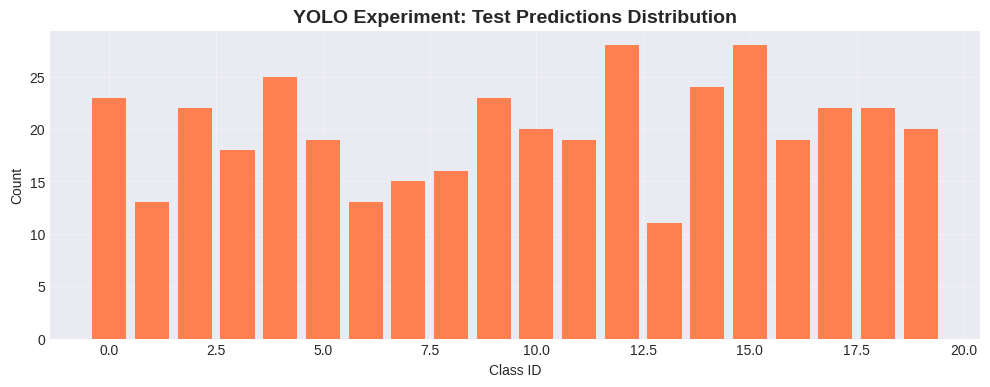


EXPERIMENT 4 (YOLO) COMPLETE!
Best Val Accuracy: 0.9515


In [ ]:




# ============================================================================
# YOLO TEST PREDICTIONS
# CRITICAL: Test images MUST also be YOLO preprocessed to match training!
# ============================================================================

print("\n" + "="*70)
print("YOLO TEST PREDICTIONS")
print("="*70)

# Load best YOLO model
yolo_checkpoint_path = os.path.join(CONFIG['checkpoint_dir'], 'convnext_yolo_best.pth')

model_yolo_test = create_model(
    'convnext_tiny',
    num_classes=NUM_CLASSES,
    pretrained=False,
    drop_path_rate=0  # No dropout for inference
)

checkpoint = torch.load(yolo_checkpoint_path)
model_yolo_test.load_state_dict(checkpoint['model_state_dict'])
model_yolo_test = model_yolo_test.to(device)
model_yolo_test.eval()

print(f"✓ YOLO model loaded (Val Acc: {checkpoint['val_acc']:.4f})")

# Get test image paths
test_image_paths_yolo = []
for root, dirs, files in os.walk(CONFIG['test_images']):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            test_image_paths_yolo.append(os.path.join(root, file))

print(f"📁 Found {len(test_image_paths_yolo)} test images")

# TTA with YOLO preprocessing
def predict_with_tta_yolo(model, image_path, yolo_detector, n_tta=5):
    """TTA predictions with YOLO preprocessing"""
    model.eval()

    # Apply YOLO detection first
    pil_image = yolo_detector.detect_and_crop(image_path)
    if pil_image is not None:
        image = np.array(pil_image)
    else:
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = np.zeros((CONFIG['img_size'], CONFIG['img_size'], 3), dtype=np.uint8)

    # TTA transforms
    tta_transforms = [
        get_advanced_transforms(CONFIG['img_size'], 'val'),  # Original
        A.Compose([A.HorizontalFlip(p=1.0)] +
                  get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
        A.Compose([A.Rotate(limit=10, p=1.0)] +
                  get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
        A.Compose([A.Rotate(limit=-10, p=1.0)] +
                  get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
        A.Compose([A.RandomBrightnessContrast(p=1.0)] +
                  get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
    ]

    predictions = []

    with torch.no_grad():
        for transform in tta_transforms[:n_tta]:
            augmented = transform(image=image)['image']
            augmented = augmented.unsqueeze(0).to(device)

            output = model(augmented)
            probs = F.softmax(output, dim=1)
            predictions.append(probs.cpu().numpy())

    # Average predictions
    avg_pred = np.mean(predictions, axis=0)
    return avg_pred

# Generate YOLO predictions with TTA
predictions_yolo = []
confidence_scores_yolo = []

print("Running YOLO + TTA predictions on test set...")
for img_path in tqdm(test_image_paths_yolo):
    avg_pred = predict_with_tta_yolo(model_yolo_test, img_path, yolo_detector, n_tta=5)
    pred_class = int(np.argmax(avg_pred))
    pred_conf = float(np.max(avg_pred))
    predictions_yolo.append(pred_class)
    confidence_scores_yolo.append(pred_conf)

# Create submission DataFrame - matching the standard format
submission_yolo = pd.DataFrame({
    'path': [os.path.basename(p) for p in test_image_paths_yolo],
    'class_idx': predictions_yolo
})

# Save submission
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
submission_path_yolo = os.path.join(CONFIG['results_dir'], f'submission_phase2_convnext_yolo_tta_{timestamp}.csv')
submission_yolo.to_csv(submission_path_yolo, index=False)

print(f"\n✅ YOLO SUBMISSION SAVED!")
print(f"📁 Path: {submission_path_yolo}")
print(f"📊 Total predictions: {len(predictions_yolo)}")
print(f"🎯 Mean confidence: {np.mean(confidence_scores_yolo):.4f}")

# Also save detailed version with confidence scores
submission_yolo_detailed = pd.DataFrame({
    'path': [os.path.basename(p) for p in test_image_paths_yolo],
    'class_idx': predictions_yolo,
    'confidence': confidence_scores_yolo,
    'class_name': [CLASS_NAMES.get(p, 'Unknown') for p in predictions_yolo]
})
detailed_path = submission_path_yolo.replace('.csv', '_detailed.csv')
submission_yolo_detailed.to_csv(detailed_path, index=False)
print(f"📁 Detailed: {detailed_path}")

# Show class distribution
print("\nClass Distribution:")
print(pd.Series(predictions_yolo).value_counts().sort_index())

# Plot distribution
plt.figure(figsize=(12, 4))
plt.bar(pd.Series(predictions_yolo).value_counts().sort_index().index,
        pd.Series(predictions_yolo).value_counts().sort_index().values,
        color='coral')
plt.title('YOLO Experiment: Test Predictions Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(CONFIG['results_dir'], 'phase2_yolo_dist.png'), dpi=150)
plt.show()

print("\n" + "="*70)
print("EXPERIMENT 4 (YOLO) COMPLETE!")
print(f"Best Val Accuracy: {best_acc_yolo:.4f}")
print("="*70)

In [14]:
# ensemble_yolo_results = []
seeds_yolo = [42, 123, 777]

In [ ]:
# ============================================================================
# EXPERIMENT 5: YOLO ENSEMBLE
# Train 3 models with different seeds on YOLO-preprocessed images
# Then ensemble their predictions with TTA for best results
# ============================================================================

"""## 11. Experiment 5: YOLO Ensemble

Training 3 ConvNeXt models on YOLO-cropped images with different seeds,
then combining their predictions for the best possible accuracy.
"""

print("\n" + "#"*80)
print("EXPERIMENT 5: YOLO Ensemble Training (3 models)")
print("Training on YOLO bird-cropped images with different seeds")
print("#"*80)

# Train 3 models with different seeds on YOLO data
ensemble_yolo_results = []
seeds_yolo = [42, 123, 777]

for i, seed in enumerate(seeds_yolo, 1):
    print(f"\n{'='*50}")
    print(f"Training YOLO Ensemble Model {i}/3 (seed={seed})")
    print(f"{'='*50}")

    set_seed(seed)

    model = create_model(
        'convnext_tiny',
        num_classes=NUM_CLASSES,
        pretrained=True,
        drop_path_rate=CONFIG['drop_path_rate']
    )

    history, best_acc = train_model_advanced(
        model,
        train_loader_yolo,  # Using YOLO dataloader
        val_loader_yolo,    # Using YOLO dataloader
        experiment_name=f'convnext_yolo_ensemble_{i}_seed{seed}',
        epochs=30,  # Slightly fewer epochs per model
        lr=CONFIG['lr'],
        config=CONFIG
    )

    ensemble_yolo_results.append({
        'seed': seed,
        'best_acc': best_acc,
        'history': history
    })

    del model
    torch.cuda.empty_cache()

print("\n" + "="*70)
print("YOLO Ensemble Training Complete!")
for i, result in enumerate(ensemble_yolo_results, 1):
    print(f"Model {i} (seed={result['seed']}): {result['best_acc']:.4f}")
print(f"Mean accuracy: {np.mean([r['best_acc'] for r in ensemble_yolo_results]):.4f}")
print("="*70)




################################################################################
EXPERIMENT 5: YOLO Ensemble Training (3 models)
Training on YOLO bird-cropped images with different seeds
################################################################################

Training YOLO Ensemble Model 1/3 (seed=42)

PHASE 2 EXPERIMENT: convnext_yolo_ensemble_1_seed42
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.6120
Val Loss: 0.6519, Val Acc: 0.8447
LR: 0.000050
✓ Best model saved: 0.8447

Epoch 2/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.5108
Val Loss: 0.3803, Val Acc: 0.8932
LR: 0.000049
✓ Best model saved: 0.8932

Epoch 3/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3922
Val Loss: 0.3737, Val Acc: 0.8738
LR: 0.000049

Epoch 4/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4598
Val Loss: 0.3403, Val Acc: 0.9320
LR: 0.000048
✓ Best model saved: 0.9320

Epoch 5/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4279
Val Loss: 0.2907, Val Acc: 0.9029
LR: 0.000047

Epoch 6/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3471
Val Loss: 0.3025, Val Acc: 0.9223
LR: 0.000045

Epoch 7/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3007
Val Loss: 0.2743, Val Acc: 0.9320
LR: 0.000044

Epoch 8/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2356
Val Loss: 0.2707, Val Acc: 0.9320
LR: 0.000042

Epoch 9/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1705
Val Loss: 0.3202, Val Acc: 0.9029
LR: 0.000040

Epoch 10/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1748
Val Loss: 0.3509, Val Acc: 0.9320
LR: 0.000038

Epoch 11/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1285
Val Loss: 0.2893, Val Acc: 0.9515
LR: 0.000035
✓ Best model saved: 0.9515

Epoch 12/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2422
Val Loss: 0.2797, Val Acc: 0.9126
LR: 0.000033

Epoch 13/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1549
Val Loss: 0.3176, Val Acc: 0.9126
LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0886
Val Loss: 0.2513, Val Acc: 0.9515
LR: 0.000028

Epoch 15/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1469
Val Loss: 0.2544, Val Acc: 0.9709
LR: 0.000026
✓ Best model saved: 0.9709

Epoch 16/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0926
Val Loss: 0.2885, Val Acc: 0.9320
LR: 0.000023

Epoch 17/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0152
Val Loss: 0.2662, Val Acc: 0.9612
LR: 0.000020

Epoch 18/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0545
Val Loss: 0.2407, Val Acc: 0.9709
LR: 0.000018

Epoch 19/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2089
Val Loss: 0.2436, Val Acc: 0.9612
LR: 0.000016

Epoch 20/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0191
Val Loss: 0.2374, Val Acc: 0.9709
LR: 0.000013

Epoch 21/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1010
Val Loss: 0.2421, Val Acc: 0.9612
LR: 0.000011

Epoch 22/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9503
Val Loss: 0.2414, Val Acc: 0.9806
LR: 0.000009
✓ Best model saved: 0.9806

Epoch 23/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1396
Val Loss: 0.2405, Val Acc: 0.9806
LR: 0.000007

Epoch 24/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0823
Val Loss: 0.2303, Val Acc: 0.9709
LR: 0.000006

Epoch 25/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1351
Val Loss: 0.2335, Val Acc: 0.9806
LR: 0.000004

Epoch 26/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0895
Val Loss: 0.2285, Val Acc: 0.9709
LR: 0.000003

Epoch 27/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9625
Val Loss: 0.2371, Val Acc: 0.9612
LR: 0.000002

Epoch 28/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0122
Val Loss: 0.2322, Val Acc: 0.9709
LR: 0.000002

Epoch 29/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0748
Val Loss: 0.2331, Val Acc: 0.9612
LR: 0.000001

Epoch 30/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0419
Val Loss: 0.2288, Val Acc: 0.9709
LR: 0.000001

Training Complete!
Best Val Accuracy: 0.9806
Improvement over Phase 1: 5.83%
Total Time: 39.63 minutes

Training YOLO Ensemble Model 2/3 (seed=123)

PHASE 2 EXPERIMENT: convnext_yolo_ensemble_2_seed123
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.5442
Val Loss: 0.6914, Val Acc: 0.8738
LR: 0.000050
✓ Best model saved: 0.8738

Epoch 2/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.5727
Val Loss: 0.4559, Val Acc: 0.8932
LR: 0.000049
✓ Best model saved: 0.8932

Epoch 3/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4457
Val Loss: 0.4625, Val Acc: 0.9223
LR: 0.000049
✓ Best model saved: 0.9223

Epoch 4/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4309
Val Loss: 0.3772, Val Acc: 0.9126
LR: 0.000048

Epoch 5/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2901
Val Loss: 0.2934, Val Acc: 0.8932
LR: 0.000047

Epoch 6/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3833
Val Loss: 0.3772, Val Acc: 0.8835
LR: 0.000045

Epoch 7/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3557
Val Loss: 0.3715, Val Acc: 0.8835
LR: 0.000044

Epoch 8/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2686
Val Loss: 0.4157, Val Acc: 0.8932
LR: 0.000042

Epoch 9/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1942
Val Loss: 0.3564, Val Acc: 0.9029
LR: 0.000040

Epoch 10/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2041
Val Loss: 0.3186, Val Acc: 0.9320
LR: 0.000038
✓ Best model saved: 0.9320

Epoch 11/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2128
Val Loss: 0.3466, Val Acc: 0.9223
LR: 0.000035

Epoch 12/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2362
Val Loss: 0.3687, Val Acc: 0.9126
LR: 0.000033

Epoch 13/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0628
Val Loss: 0.3446, Val Acc: 0.9320
LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1411
Val Loss: 0.3147, Val Acc: 0.9223
LR: 0.000028

Epoch 15/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2313
Val Loss: 0.3745, Val Acc: 0.9126
LR: 0.000026

Epoch 16/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2235
Val Loss: 0.3216, Val Acc: 0.9223
LR: 0.000023

Epoch 17/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0475
Val Loss: 0.3023, Val Acc: 0.9417
LR: 0.000020
✓ Best model saved: 0.9417

Epoch 18/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1434
Val Loss: 0.3422, Val Acc: 0.9223
LR: 0.000018

Epoch 19/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0908
Val Loss: 0.3102, Val Acc: 0.9223
LR: 0.000016

Epoch 20/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9540
Val Loss: 0.3167, Val Acc: 0.9223
LR: 0.000013

Epoch 21/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1067
Val Loss: 0.2892, Val Acc: 0.9320
LR: 0.000011

Epoch 22/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1344
Val Loss: 0.2800, Val Acc: 0.9320
LR: 0.000009

Epoch 23/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0797
Val Loss: 0.2980, Val Acc: 0.9417
LR: 0.000007

Epoch 24/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1246
Val Loss: 0.2668, Val Acc: 0.9223
LR: 0.000006

Epoch 25/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9806
Val Loss: 0.2923, Val Acc: 0.9417
LR: 0.000004

Epoch 26/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1632
Val Loss: 0.2867, Val Acc: 0.9320
LR: 0.000003

Epoch 27/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1640
Val Loss: 0.2934, Val Acc: 0.9223
LR: 0.000002

Early stopping at epoch 27

Training Complete!
Best Val Accuracy: 0.9417
Improvement over Phase 1: 1.94%
Total Time: 28.17 minutes

Training YOLO Ensemble Model 3/3 (seed=777)

PHASE 2 EXPERIMENT: convnext_yolo_ensemble_3_seed777
Parameters: 27,835,508 trainable / 27,835,508 total
MixUp: True, CutMix: True
Label smoothing: 0.1
Drop path rate: 0.1

Epoch 1/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 2.5432
Val Loss: 0.7095, Val Acc: 0.8835
LR: 0.000050
✓ Best model saved: 0.8835

Epoch 2/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.7167
Val Loss: 0.4301, Val Acc: 0.9126
LR: 0.000049
✓ Best model saved: 0.9126

Epoch 3/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4992
Val Loss: 0.2987, Val Acc: 0.9029
LR: 0.000049

Epoch 4/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.4199
Val Loss: 0.3309, Val Acc: 0.9029
LR: 0.000048

Epoch 5/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2917
Val Loss: 0.3061, Val Acc: 0.9223
LR: 0.000047
✓ Best model saved: 0.9223

Epoch 6/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.3401
Val Loss: 0.3026, Val Acc: 0.9126
LR: 0.000045

Epoch 7/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2199
Val Loss: 0.3059, Val Acc: 0.9029
LR: 0.000044

Epoch 8/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2748
Val Loss: 0.2788, Val Acc: 0.9223
LR: 0.000042

Epoch 9/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1389
Val Loss: 0.4226, Val Acc: 0.9029
LR: 0.000040

Epoch 10/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2957
Val Loss: 0.2698, Val Acc: 0.9320
LR: 0.000038
✓ Best model saved: 0.9320

Epoch 11/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2127
Val Loss: 0.2870, Val Acc: 0.9320
LR: 0.000035

Epoch 12/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0816
Val Loss: 0.2902, Val Acc: 0.9223
LR: 0.000033

Epoch 13/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1902
Val Loss: 0.2762, Val Acc: 0.9320
LR: 0.000031

Epoch 14/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.2418
Val Loss: 0.3033, Val Acc: 0.9223
LR: 0.000028

Epoch 15/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1729
Val Loss: 0.3278, Val Acc: 0.9223
LR: 0.000026

Epoch 16/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1220
Val Loss: 0.2768, Val Acc: 0.9126
LR: 0.000023

Epoch 17/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1651
Val Loss: 0.2817, Val Acc: 0.9320
LR: 0.000020

Epoch 18/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0223
Val Loss: 0.2700, Val Acc: 0.9417
LR: 0.000018
✓ Best model saved: 0.9417

Epoch 19/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0845
Val Loss: 0.2699, Val Acc: 0.9320
LR: 0.000016

Epoch 20/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1894
Val Loss: 0.2909, Val Acc: 0.9320
LR: 0.000013

Epoch 21/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0351
Val Loss: 0.2808, Val Acc: 0.9417
LR: 0.000011

Epoch 22/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1177
Val Loss: 0.2652, Val Acc: 0.9223
LR: 0.000009

Epoch 23/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0903
Val Loss: 0.2560, Val Acc: 0.9320
LR: 0.000007

Epoch 24/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9716
Val Loss: 0.2624, Val Acc: 0.9417
LR: 0.000006

Epoch 25/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.1925
Val Loss: 0.2846, Val Acc: 0.9417
LR: 0.000004

Epoch 26/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.8765
Val Loss: 0.2544, Val Acc: 0.9515
LR: 0.000003
✓ Best model saved: 0.9515

Epoch 27/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0131
Val Loss: 0.2582, Val Acc: 0.9417
LR: 0.000002

Epoch 28/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0986
Val Loss: 0.2626, Val Acc: 0.9417
LR: 0.000002

Epoch 29/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 1.0148
Val Loss: 0.2577, Val Acc: 0.9515
LR: 0.000001

Epoch 30/30


Training:   0%|          | 0/34 [00:00<?, ?it/s]

Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9953
Val Loss: 0.2561, Val Acc: 0.9515
LR: 0.000001

Training Complete!
Best Val Accuracy: 0.9515
Improvement over Phase 1: 2.92%
Total Time: 31.38 minutes

YOLO Ensemble Training Complete!
Model 1 (seed=42): 0.9806
Model 2 (seed=123): 0.9417
Model 3 (seed=777): 0.9515
Mean accuracy: 0.9579

YOLO ENSEMBLE TEST PREDICTIONS
✓ Loaded model 1 (seed=42, Val Acc: 0.9806)
✓ Loaded model 2 (seed=123, Val Acc: 0.9417)
✓ Loaded model 3 (seed=777, Val Acc: 0.9515)

📊 Loaded 3 models for ensemble
📁 Found 400 test images
Running YOLO Ensemble + TTA predictions on test set...
This combines 3 models × 5 TTA augmentations = 15 predictions per image


  0%|          | 0/400 [00:00<?, ?it/s]

NameError: name 'datetime' is not defined


YOLO ENSEMBLE TEST PREDICTIONS
✓ Loaded model 1 (seed=42, Val Acc: 0.9806)
✓ Loaded model 2 (seed=123, Val Acc: 0.9417)
✓ Loaded model 3 (seed=777, Val Acc: 0.9515)

📊 Loaded 3 models for ensemble
📁 Found 400 test images
Running YOLO Ensemble + TTA predictions on test set...
This combines 3 models × 5 TTA augmentations = 15 predictions per image


  0%|          | 0/400 [00:00<?, ?it/s]


✅ YOLO ENSEMBLE SUBMISSION SAVED!
📁 Path: /content/drive/My Drive/ml_results/phase2_results/submission_phase2_yolo_ensemble_3models_tta_20260208_160548.csv
📊 Total predictions: 400
🎯 Mean confidence: 0.7797
📁 Detailed: /content/drive/My Drive/ml_results/phase2_results/submission_phase2_yolo_ensemble_3models_tta_20260208_160548_detailed.csv

Class Distribution:
0     21
1     14
2     21
3     19
4     21
5     19
6     14
7     18
8     18
9     24
10    19
11    21
12    13
13    25
14    21
15    29
16    21
17    21
18    22
19    19
Name: count, dtype: int64


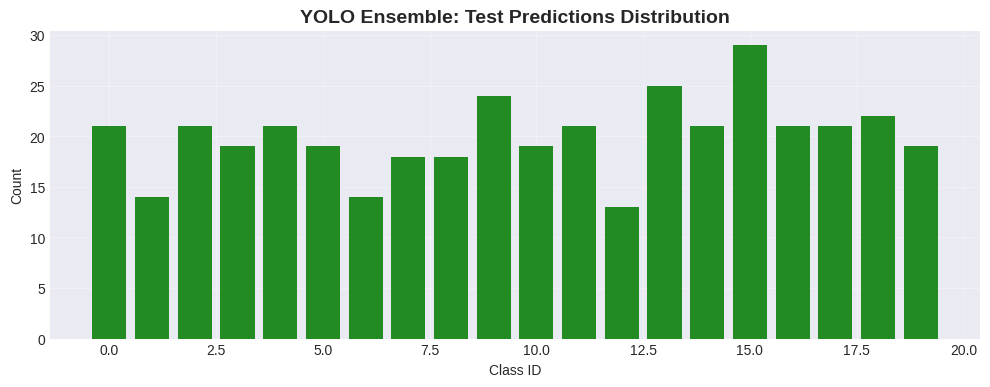


🎉 ALL EXPERIMENTS COMPLETE!

Experiment Results Summary:


NameError: name 'best_acc_exp1' is not defined

In [20]:
from datetime import datetime
# ============================================================================
# YOLO ENSEMBLE TEST PREDICTIONS WITH TTA
# ============================================================================

print("\n" + "="*70)
print("YOLO ENSEMBLE TEST PREDICTIONS")
print("="*70)

# Load all 3 YOLO ensemble models
yolo_ensemble_models = []

for i, seed in enumerate(seeds_yolo, 1):
    checkpoint_path = os.path.join(
        CONFIG['checkpoint_dir'],
        f'convnext_yolo_ensemble_{i}_seed{seed}_best.pth'
    )

    model = create_model(
        'convnext_tiny',
        num_classes=NUM_CLASSES,
        pretrained=False,
        drop_path_rate=0  # No dropout for inference
    )

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    yolo_ensemble_models.append({
        'model': model,
        'val_acc': checkpoint['val_acc'],
        'seed': seed
    })
    print(f"✓ Loaded model {i} (seed={seed}, Val Acc: {checkpoint['val_acc']:.4f})")

print(f"\n📊 Loaded {len(yolo_ensemble_models)} models for ensemble")

# Get test image paths
test_image_paths_ensemble = []
for root, dirs, files in os.walk(CONFIG['test_images']):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            test_image_paths_ensemble.append(os.path.join(root, file))

print(f"📁 Found {len(test_image_paths_ensemble)} test images")

# Ensemble TTA prediction function
def predict_ensemble_with_tta_yolo(models, image_path, yolo_detector, n_tta=5):
    """
    Ensemble prediction with TTA and YOLO preprocessing.
    Averages predictions across all models and all TTA augmentations.
    """
    # Apply YOLO detection first
    pil_image = yolo_detector.detect_and_crop(image_path)
    if pil_image is not None:
        image = np.array(pil_image)
    else:
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = np.zeros((CONFIG['img_size'], CONFIG['img_size'], 3), dtype=np.uint8)

    # TTA transforms
    tta_transforms = [
        get_advanced_transforms(CONFIG['img_size'], 'val'),  # Original
        A.Compose([A.HorizontalFlip(p=1.0)] +
                  get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
        A.Compose([A.Rotate(limit=10, p=1.0)] +
                  get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
        A.Compose([A.Rotate(limit=-10, p=1.0)] +
                  get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
        A.Compose([A.RandomBrightnessContrast(p=1.0)] +
                  get_advanced_transforms(CONFIG['img_size'], 'val').transforms),
    ]

    all_predictions = []

    # For each model in ensemble
    for model_info in models:
        model = model_info['model']
        model.eval()

        # For each TTA augmentation
        with torch.no_grad():
            for transform in tta_transforms[:n_tta]:
                augmented = transform(image=image)['image']
                augmented = augmented.unsqueeze(0).to(device)

                output = model(augmented)
                probs = F.softmax(output, dim=1)
                all_predictions.append(probs.cpu().numpy())

    # Average all predictions (models x TTA augmentations)
    avg_pred = np.mean(all_predictions, axis=0)
    return avg_pred

# Generate ensemble predictions
predictions_yolo_ensemble = []
confidence_scores_yolo_ensemble = []

print("Running YOLO Ensemble + TTA predictions on test set...")
print(f"This combines {len(yolo_ensemble_models)} models × 5 TTA augmentations = {len(yolo_ensemble_models) * 5} predictions per image")

for img_path in tqdm(test_image_paths_ensemble):
    avg_pred = predict_ensemble_with_tta_yolo(
        yolo_ensemble_models,
        img_path,
        yolo_detector,
        n_tta=5
    )
    pred_class = int(np.argmax(avg_pred))
    pred_conf = float(np.max(avg_pred))
    predictions_yolo_ensemble.append(pred_class)
    confidence_scores_yolo_ensemble.append(pred_conf)

# Create submission DataFrame
submission_yolo_ensemble = pd.DataFrame({
    'path': [os.path.basename(p) for p in test_image_paths_ensemble],
    'class_idx': predictions_yolo_ensemble
})

# Save submission
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
submission_path_yolo_ensemble = os.path.join(
    CONFIG['results_dir'],
    f'submission_phase2_yolo_ensemble_{len(yolo_ensemble_models)}models_tta_{timestamp}.csv'
)
submission_yolo_ensemble.to_csv(submission_path_yolo_ensemble, index=False)

print(f"\n✅ YOLO ENSEMBLE SUBMISSION SAVED!")
print(f"📁 Path: {submission_path_yolo_ensemble}")
print(f"📊 Total predictions: {len(predictions_yolo_ensemble)}")
print(f"🎯 Mean confidence: {np.mean(confidence_scores_yolo_ensemble):.4f}")

# Save detailed version
submission_yolo_ensemble_detailed = pd.DataFrame({
    'path': [os.path.basename(p) for p in test_image_paths_ensemble],
    'class_idx': predictions_yolo_ensemble,
    'confidence': confidence_scores_yolo_ensemble,
    'class_name': [CLASS_NAMES.get(p, 'Unknown') for p in predictions_yolo_ensemble]
})
detailed_path_ensemble = submission_path_yolo_ensemble.replace('.csv', '_detailed.csv')
submission_yolo_ensemble_detailed.to_csv(detailed_path_ensemble, index=False)
print(f"📁 Detailed: {detailed_path_ensemble}")

# Clean up ensemble models
for model_info in yolo_ensemble_models:
    del model_info['model']
torch.cuda.empty_cache()

# Show class distribution
print("\nClass Distribution:")
print(pd.Series(predictions_yolo_ensemble).value_counts().sort_index())

# Plot distribution
plt.figure(figsize=(12, 4))
plt.bar(pd.Series(predictions_yolo_ensemble).value_counts().sort_index().index,
        pd.Series(predictions_yolo_ensemble).value_counts().sort_index().values,
        color='forestgreen')
plt.title('YOLO Ensemble: Test Predictions Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class ID')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.savefig(os.path.join(CONFIG['results_dir'], 'phase2_yolo_ensemble_dist.png'), dpi=150)
plt.show()

# Final summary
print("\n" + "="*80)
print("🎉 ALL EXPERIMENTS COMPLETE!")
print("="*80)
print("\nExperiment Results Summary:")
print(f"  Exp 1 (Advanced 224):     {best_acc_exp1:.4f}")
print(f"  Exp 2 (Progressive):      {best_acc_exp2:.4f}")
print(f"  Exp 3 (Ensemble):         {np.mean([r['best_acc'] for r in ensemble_results]):.4f} (mean of 3)")
print(f"  Exp 4 (YOLO Single):      {best_acc_yolo:.4f}")
print(f"  Exp 5 (YOLO Ensemble):    {np.mean([r['best_acc'] for r in ensemble_yolo_results]):.4f} (mean of 3)")
print("\nSubmission files generated:")
print(f"  • submission_phase2_convnext_yolo_tta_*.csv")
print(f"  • {os.path.basename(submission_path_yolo_ensemble)}")
print("="*80)